# Quickstart: Querying PDF With Astra and LangChain

### A question-answering demo using Astra DB and LangChain, powered by Vector Search

#### Pre-requisites:

You need a **_Serverless Cassandra with Vector Search_** database on [Astra DB](https://astra.datastax.com) to run this demo. As outlined in more detail [here](https://docs.datastax.com/en/astra-serverless/docs/vector-search/quickstart.html#_prepare_for_using_your_vector_database), you should get a DB Token with role _Database Administrator_ and copy your Database ID: these connection parameters are needed momentarily.

You also need an [OpenAI API Key](https://cassio.org/start_here/#llm-access) for this demo to work.

#### What you will do:

- Setup: import dependencies, provide secrets, create the LangChain vector store;
- Run a Question-Answering loop retrieving the relevant headlines and having an LLM construct the answer.

Install the required dependencies:

In [ ]:
!pip install -q cassio datasets langchain openai tiktoken

Import the packages you'll need:

In [ ]:
# LangChain components to use
from langchain.vectorstores.cassandra import Cassandra
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain.llms import OpenAI
from langchain.embeddings import OpenAIEmbeddings

# Support for dataset retrieval with Hugging Face
from datasets import load_dataset

# With CassIO, the engine powering the Astra DB integration in LangChain,
# you will also initialize the DB connection:
import cassio

In [ ]:
!pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.3 MB/s eta 0:00:00


In [ ]:
from PyPDF2 import PdfReader

### Setup

In [ ]:
ASTRA_DB_APPLICATION_TOKEN = "AstraCS:RKpdcdfIgtaclGeNMdKDvQKR:fe218050c76d036a5fa71e492ffee295864c6ab14770b0b6faf2975ed2ad6c20" # enter the "AstraCS:..." string found in in your Token JSON file
ASTRA_DB_ID = "b6f1b17a-750b-40f0-a56f-2f1c0f6ea706" # enter your Database ID

OPENAI_API_KEY = "your open AI key" # enter your OpenAI key

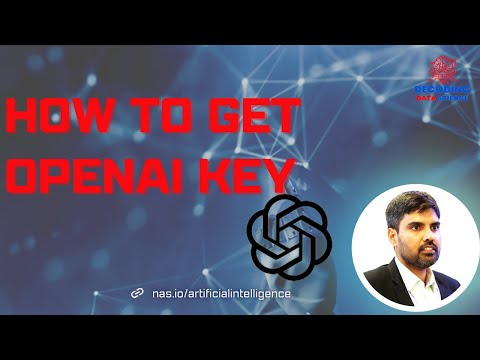

In [3]:
#if don't have openAI key look at this video

from IPython.display import YouTubeVideo
YouTubeVideo('CVnTzj-qhCU')

#### Provide your secrets:

Replace the following with your Astra DB connection details and your OpenAI API key:

In [ ]:
# provide the path of  pdf file/files.
pdfreader = PdfReader('budget_speech.pdf')

In [ ]:
from typing_extensions import Concatenate
# read text from pdf
raw_text = ''
for i, page in enumerate(pdfreader.pages):
    content = page.extract_text()
    if content:
        raw_text += content

In [ ]:
raw_text

"GOVERNMENT OF INDIA\nBUDGET 2023-2024\nSPEECH\nOF\nNIRMALA SITHARAMAN\nMINISTER OF FINANCE\nFebruary 1,  2023CONTENTS \nPART-A \n Page No.  \n\uf0b7 Introduction 1 \n\uf0b7 Achievements since 2014: Leaving no one behind 2 \n\uf0b7 Vision for Amrit Kaal  – an empowered and inclusive economy 3 \n\uf0b7 Priorities of this Budget 5 \ni. Inclusive Development  \nii. Reaching the Last Mile \niii. Infrastructure and Investment \niv. Unleashing the Potential \nv. Green Growth \nvi. Youth Power  \nvii. Financial Sector  \n \n \n \n \n \n \n \n \n\uf0b7 Fiscal Management 24 \nPART B  \n  \nIndirect Taxes  27 \n\uf0b7 Green Mobility  \n\uf0b7 Electronics   \n\uf0b7 Electrical   \n\uf0b7 Chemicals and Petrochemicals   \n\uf0b7 Marine products  \n\uf0b7 Lab Grown Diamonds  \n\uf0b7 Precious Metals  \n\uf0b7 Metals  \n\uf0b7 Compounded Rubber  \n\uf0b7 Cigarettes  \n  \nDirect Taxes  30 \n\uf0b7 MSMEs and Professionals   \n\uf0b7 Cooperation  \n\uf0b7 Start-Ups  \n\uf0b7 Appeals  \n\uf0b7 Better ta

Initialize the connection to your database:

_(do not worry if you see a few warnings, it's just that the drivers are chatty about negotiating protocol versions with the DB.)_

In [ ]:
len(raw_text)

89281

In [ ]:
import cassio

In [ ]:
print(ASTRA_DB_APPLICATION_TOKEN)
print(ASTRA_DB_ID)

AstraCS:RKpdcdfIgtaclGeNMdKDvQKR:fe218050c76d036a5fa71e492ffee295864c6ab14770b0b6faf2975ed2ad6c20
56eada22-55b6-4100-aeab-a83b9f82e


In [ ]:
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID)

ERROR:cassandra.connection:Closing connection <LibevConnection(132771643970016) b6f1b17a-750b-40f0-a56f-2f1c0f6ea706-us-east1.db.astra.datastax.com:29042:a86d16d4-63bf-4323-8fff-3c96cbeab4bb> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


In [ ]:
llm = OpenAI(openai_api_key=OPENAI_API_KEY)
embedding = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

Create your LangChain vector store ... backed by Astra DB!

In [ ]:
astra_vector_store = Cassandra(
    embedding=embedding,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None,
)

In [ ]:
from langchain.text_splitter import CharacterTextSplitter
# We need to split the text using Character Text Split such that it sshould not increse token size
text_splitter = CharacterTextSplitter(
    separator = "\n",
    chunk_size = 800,
    chunk_overlap  = 200,
    length_function = len,
)
texts = text_splitter.split_text(raw_text)

In [ ]:
texts[:50]

['GOVERNMENT OF INDIA\nBUDGET 2023-2024\nSPEECH\nOF\nNIRMALA SITHARAMAN\nMINISTER OF FINANCE\nFebruary 1,  2023CONTENTS \nPART-A \n Page No.  \n\uf0b7 Introduction 1 \n\uf0b7 Achievements since 2014: Leaving no one behind 2 \n\uf0b7 Vision for Amrit Kaal  – an empowered and inclusive economy 3 \n\uf0b7 Priorities of this Budget 5 \ni. Inclusive Development  \nii. Reaching the Last Mile \niii. Infrastructure and Investment \niv. Unleashing the Potential \nv. Green Growth \nvi. Youth Power  \nvii. Financial Sector  \n \n \n \n \n \n \n \n \n\uf0b7 Fiscal Management 24 \nPART B  \n  \nIndirect Taxes  27 \n\uf0b7 Green Mobility  \n\uf0b7 Electronics   \n\uf0b7 Electrical   \n\uf0b7 Chemicals and Petrochemicals   \n\uf0b7 Marine products  \n\uf0b7 Lab Grown Diamonds  \n\uf0b7 Precious Metals  \n\uf0b7 Metals  \n\uf0b7 Compounded Rubber  \n\uf0b7 Cigarettes  \n  \nDirect Taxes  30 \n\uf0b7 MSMEs and Professionals',
 '\uf0b7 Chemicals and Petrochemicals   \n\uf0b7 Marine products  \n\uf0b7 La

### Load the dataset into the vector store



In [ ]:

astra_vector_store.add_texts(texts[:50])

print("Inserted %i headlines." % len(texts[:50]))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 50 headlines.


### Run the QA cycle

Simply run the cells and ask a question -- or `quit` to stop. (you can also stop execution with the "▪" button on the top toolbar)

Here are some suggested questions:
- _What is the current GDP?_
- _How much the agriculture target will be increased to and what the focus will be_


In [ ]:
first_question = True
while True:
    if first_question:
        query_text = input("\nEnter your question (or type 'quit' to exit): ").strip()
    else:
        query_text = input("\nWhat's your next question (or type 'quit' to exit): ").strip()

    if query_text.lower() == "quit":
        break

    if query_text == "":
        continue

    first_question = False

    print("\nQUESTION: \"%s\"" % query_text)
    answer = astra_vector_index.query(query_text, llm=llm).strip()
    print("ANSWER: \"%s\"\n" % answer)

    print("FIRST DOCUMENTS BY RELEVANCE:")
    for doc, score in astra_vector_store.similarity_search_with_score(query_text, k=4):
        print("    [%0.4f] \"%s ...\"" % (score, doc.page_content[:84]))


Enter your question (or type 'quit' to exit): What is the current GDP?

QUESTION: "What is the current GDP?"


ANSWER: "The current GDP is estimated to be at 7 per cent, the highest among all major economies."

FIRST DOCUMENTS BY RELEVANCE:
    [0.8953] "estimated to be at 7 per cent. It is notable that this is the highest among all 
the ..."
    [0.8947] "With the theme of ‘ Vasudhaiva Kutumbakam’ , we are steering an 
ambitious, people-c ..."
    [0.8941] "multiplier impact on growth and employment. After the subdued period of 
the pandemi ..."
    [0.8907] "February 1, 2023 
Hon’ble Speaker,  
 I present the Budget for 2023-24. This is the  ..."

What's your next question (or type 'quit' to exit): How much the agriculture target will be increased to and what the focus will be

QUESTION: "How much the agriculture target will be increased to and what the focus will be"


ANSWER: "The agriculture credit target will be increased to `20 lakh crore with a focus on animal husbandry, dairy, and fisheries."

FIRST DOCUMENTS BY RELEVANCE:
    [0.9324] "of Millet Research, Hyderabad  will be supported as the Centre of Excellence 
for sh ..."
    [0.9205] "Agriculture Accelerator Fund  
17. An Agriculture Accelerator Fund will be set-up to ..."
    [0.9117] "Kashmir, Ladakh and the North-East. This Budget builds on those efforts.  
Agricultu ..."
    [0.9072] "grant will be provided to one of the IITs for five years.   
75. To reduce the cost  ..."

What's your next question (or type 'quit' to exit): exit



QUESTION: "exit"


ANSWER: "I don't know."

FIRST DOCUMENTS BY RELEVANCE:
    [0.8750] "environment for business as reflected in several global indices. We have 
made signi ..."
    [0.8711] "Prayas  is essential.   
12. The economic agenda for achieving this vision focuses o ..."
    [0.8710] "material to these libraries.  
Priority 2: Reaching the Last Mile 
35. Prime Ministe ..."
    [0.8708] "encouraged to leverage resources from the grants of the 15th Finance 
Commission, as ..."

What's your next question (or type 'quit' to exit): quit
